# Global mean state bias and trend biases over 3 major basins

In [1]:
import os
import cftime
import dask
import xarray as xr
import numpy as np
import nc_time_axis
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=8, processes=False)
client

/storage1/home1/chiaweih/anaconda2/envs/python3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: inproc://128.196.236.68/15265/1 Dashboard: http://localhost:39562/status,Cluster Workers: 1 Cores: 8 Memory: 67.54 GB


In [2]:
import warnings
warnings.simplefilter("ignore")

from mem_track import used_memory
used_memory()

used 133.500000 MB


# Model setup

In [3]:
#### possible input info from external text file
# constant setting
syear = 1993           
fyear = 2007
tp_lat_region = [-90,90]     # extract model till latitude

Model_varname = ['zos']
Area_name = ['areacello']

Model_name = ['JRA','CORE']
Model_legend_name = ['JRA55-do','CORE']

# standard model (interpolated to this model)
Model_standard = 'JRA'
Variable_standard = 'zos'
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/'
modelfile = 'JRA_zos_all.zarr'
path_standard = modeldir+modelfile

# inputs
modelin = {}
path = {}
model = Model_name[0]
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/'
modelfile = [['JRA_zos_all.zarr']]
path[model]=[modeldir,modelfile]

model = Model_name[1]
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/CORE/'
modelfile = [['CORE_zos_all.zarr']]
path[model]=[modeldir,modelfile]



for nmodel,model in enumerate(Model_name):
    modeldir = path[model][0]
    modelfile = path[model][1]
    multivar = []
    for file in modelfile :
        if len(file) == 1 :
            multivar.append([os.path.join(modeldir,file[0])])
        elif len(file) > 1 :
            multifile = []
            for ff in file :
                multifile.append(os.path.join(modeldir,ff))
            multivar.append(multifile)
    modelin[model] = multivar



# Observation

In [4]:
#### possible input info from external text file
# constant setting
obs_year_range = [[1993,2018,9]]


# standard model (interpolated to this model)
Model_standard = 'JRA'
tp_lat_region = [-90,90]     # extract model till latitude

Obs_varname = [['adt']]

Obs_name = ['CMEMS']

# inputs
obsin = {}
obspath = {}

obs = Obs_name[0]
obsdir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/CMEMS/'
obsfile = [['dt_global_allsat_phy_l4_monthly_adt.nc']]
obspath[obs]=[obsdir,obsfile]


for nobs,obs in enumerate(Obs_name):
    obsdir = obspath[obs][0]
    obsfile = obspath[obs][1]
    multivar = []
    for file in obsfile :
        if len(file) == 1 :
            multivar.append([os.path.join(obsdir,file[0])])
        elif len(file) > 1 :
            multifile = []
            for ff in file :
                multifile.append(os.path.join(obsdir,ff))
            multivar.append(multifile)
    obsin[obs] = multivar

In [5]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
ds_obs_mlist = {}
obs_mean_mlist = {}
obs_season_mlist = {}
obs_linear_mlist = {}

In [6]:
import spherical_area as sa
from xr_ufunc import da_linregress

#### obs
for nobs,obs in enumerate(Obs_name):
    ds_obs_list = {}
    obs_mean_list = {}
    obs_season_list = {}
    obs_linear_list = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        print('read %s %s'%(obs,var))
        
        # read input data
        #-- single file
        if len(obsin[obs][nvar]) == 1 :  
            
            # find out dimension name 
            da = xr.open_dataset(obsin[obs][nvar][0],chunks={})
            obsdims = list(da[var].dims)
        
            ds_obs = xr.open_dataset(obsin[obs][nvar][0],chunks={obsdims[0]:50,obsdims[1]:50,obsdims[2]:50},use_cftime=True)
         
        #-- multi-file merge (same variable)
        elif len(obsin[obs][nvar]) > 1 :
            for nf,file in enumerate(obsin[obs][nvar]):
                # find out dimension name 
                da = xr.open_dataset(file,chunks={})
                obsdims = list(da[var].dims)
            
                ds_obs_sub = xr.open_dataset(file,chunks={obsdims[0]:50,obsdims[1]:50,obsdims[2]:50},use_cftime=True)
                if nf == 0 :
                    ds_obs = ds_obs_sub
                else:
                    ds_obs = xr.concat([ds_obs,ds_obs_sub],dim='time',data_vars='minimal')
                    
        ############## CMEMS ##############       
        if obs in ['CMEMS']:
            syear_obs = obs_year_range[nobs][0]
            fyear_obs = obs_year_range[nobs][1]
            fmon_obs = obs_year_range[nobs][2]
            #### create time axis for overlapping period
            timeax = xr.cftime_range(start=cftime.datetime(syear_obs,1,1),end=cftime.datetime(fyear_obs,fmon_obs,1),freq='MS')
            timeax = timeax.to_datetimeindex()    # cftime => datetime64
            ds_obs.time.values = timeax                   
                 
            # calculate global mean sea level 
            da_area = sa.da_area(ds_obs, lonname='longitude', latname='latitude', 
                                 xname='longitude', yname='latitude', model=None)
            da_glo_mean = (ds_obs*da_area).sum(dim=['longitude','latitude'])/(ds_obs/ds_obs*da_area).sum(dim=['longitude','latitude']).compute()
#             da_glo_mean = (ds_obs*da_area).sum(dim=)/da_area.sum(dim=['longitude','latitude'])
            ds_obs = ds_obs-da_glo_mean

            # rename 
            ds_obs = ds_obs.rename({'longitude':'lon','latitude':'lat'})
        else:
            syear_obs = obs_year_range[nobs][0]
            fyear_obs = obs_year_range[nobs][1]
            #### create time axis for overlapping period
            timeax = xr.cftime_range(start=cftime.datetime(syear_obs,1,1),end=cftime.datetime(fyear_obs,12,31),freq='MS')
            timeax = timeax.to_datetimeindex()    # cftime => datetime64
            ds_obs.time.values = timeax
            
     
        #crop data (time)
        ds_obs = ds_obs[var]\
                          .where((ds_obs['time.year'] >= syear)&\
                                 (ds_obs['time.year'] <= fyear)\
                                 ,drop=True)
        ds_obs = ds_obs\
                          .where((ds_obs.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_obs.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_obs_list[var] = ds_obs
        
        # calculate mean 
        obs_mean_list[var] = (ds_obs_list[var].mean(dim='time')).compute()
        ds_obs_list[var] = ds_obs_list[var]-obs_mean_list[var]
        
        # calculate seasonality
        obs_season_list[var] = ds_obs_list[var].groupby('time.month').mean(dim='time').compute()
        ds_obs_list[var] = ds_obs_list[var].groupby('time.month')-obs_season_list[var]
        
        # remove linear trend 
        obs_linear_list[var] = da_linregress(ds_obs_list[var].load(),xname='lon',yname='lat',stTconfint=0.99,skipna=True) 

    obs_linear_mlist[obs] = obs_linear_list
    obs_mean_mlist[obs] = obs_mean_list
    obs_season_mlist[obs] = obs_season_list
    ds_obs_mlist[obs] = ds_obs_list

read CMEMS adt


In [7]:
used_memory()

used 4710.613281 MB


# Regridding observation

In [10]:
#### models
da_model_standard = xr.open_zarr(path_standard).isel(time=0).load()     
da_model_standard = da_model_standard

In [11]:
used_memory()

used 4638.851562 MB


In [12]:
import importlib
import create_ocean_mask
importlib.reload(create_ocean_mask)
from create_ocean_mask import levitus98

# # calculate zonal mean in the Pacific Basin
# from create_ocean_mask import levitus98

# da_pacific = levitus98(da_model_standard,
#                        basin=['pac'],
#                        reuse_weights=True, 
#                        newvar=True, 
#                        lon_name='x',
#                        lat_name='y', 
#                        new_regridder_name='')


da_atlantic,\
da_indian,\
da_pacific,\
da_3basin,\
da_indopac = levitus98(da_model_standard,
                       basin=['all'],
                       reuse_weights=True, 
                       newvar=True, 
                       lon_name='x',
                       lat_name='y', 
                       new_regridder_name='')

Create weight file: basin_pacific_regrid.nc
Create weight file: basin_indian_regrid.nc
Create weight file: basin_atlantic_regrid.nc


In [13]:
import xesmf as xe
regridder_mlist = {}
# create regridder
for nobs,obs in enumerate(Obs_name):
    regridder_list = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        regridder = xe.Regridder(ds_obs_mlist[obs][var], 
                                 da_model_standard, 
                                 'bilinear',
                                 filename='%s_%s2%s_%s.nc'%(obs,var,Model_standard,Variable_standard),
                                 periodic=True,
                                 reuse_weights=False)
        regridder_list['%s_%s2%s_%s'%(obs,var,Model_standard,Variable_standard)] = regridder
    regridder_mlist[obs] = regridder_list

Overwrite existing file: CMEMS_adt2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.


In [14]:
#### regridding all field 
for nobs,obs in enumerate(Obs_name):
    for nvar,var in enumerate(Obs_varname[nobs]):
        ds_obs_mlist[obs][var] = \
          regridder_mlist[obs]['%s_%s2%s_%s'%(obs,var,Model_standard,Variable_standard)](ds_obs_mlist[obs][var])
        ds_obs_mlist[obs][var]['x'] = da_model_standard.x.values
        ds_obs_mlist[obs][var]['y'] = da_model_standard.y.values

# Read Model and preprocessing

In [15]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
nmodel = len(Model_name)
nvar = len(Model_varname)

ds_model_mlist = {}
mean_mlist = {}
season_mlist = {}
linear_mlist = {}

In [16]:
#### models
import sys
import spherical_area as sa
from xr_ufunc import da_linregress

da_glo_mean_model = {}
da_glo_mean_model_test = {}
for nmodel,model in enumerate(Model_name):
    ds_model_list = {}
    mean_list = {}
    season_list = {}
    linear_list = {}
    for nvar,var in enumerate(Model_varname):
        print('read %s %s'%(model,var))
        
        # read input data
        #-- single file
        if len(modelin[model][nvar]) == 1 :   
            ds_model = xr.open_zarr(modelin[model][nvar][0])            
        #-- multi-file merge (same variable)
        elif len(modelin[model][nvar]) > 1 :
            for nf,file in enumerate(modelin[model][nvar]):
                ds_model_sub = xr.open_zarr(file)
                if nf == 0 :
                    ds_model = ds_model_sub
                else:
                    ds_model = xr.concat([ds_model,ds_model_sub],dim='time',data_vars='minimal')
                 
        # crop data (time)
        da_model = ds_model[var]\
                          .where((ds_model['time.year'] >= syear)&\
                                 (ds_model['time.year'] <= fyear)\
                                 ,drop=True)
        
#         # calculate global mean
#         da_area = sa.da_area(ds_obs_mlist['CMEMS']['adt'], lonname='lon', latname='lat', 
#                              xname='x', yname='y', model='gfdl')
#         da_glo_mean_model[model] = ((da_model*ds_obs_mlist['CMEMS']['adt']/ds_obs_mlist['CMEMS']['adt']*da_area)\
#                                     .sum(dim=['x','y'])/da_area.sum(dim=['x','y'])).compute()
#         da_model = da_model-da_glo_mean_model[model]
        
        # calculate global mean
        da_model_load = da_model.isel(time=0).load()
        da_area_test = sa.da_area(da_model_load, lonname='lon', latname='lat', xname='x', yname='y', model='gfdl')
        da_glo_mean_model_test[model] = ((da_model*da_area_test).sum(dim=['x','y'])/(da_model_load/da_model_load*da_area_test).sum(dim=['x','y'])).compute()
        da_model = da_model-da_glo_mean_model_test[model]

        # crop data (space)
        da_model = da_model\
                          .where((ds_model.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_model.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_model_list[var] = da_model
        
        # calculate mean 
        mean_list[var] = (ds_model_list[var].mean(dim='time')).compute()
        ds_model_list[var] = ds_model_list[var]-mean_list[var]
        
        # calculate seasonality
        season_list[var] = ds_model_list[var].groupby('time.month').mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var].groupby('time.month')-season_list[var]
        
        # remove linear trend 
        linear_list[var] = da_linregress(ds_model_list[var],stTconfint=0.99) 

    linear_mlist[model] = linear_list
    mean_mlist[model] = mean_list
    season_mlist[model] = season_list
    ds_model_mlist[model] = ds_model_list

read JRA zos
read CORE zos


In [17]:
# (da_glo_mean.adt-da_glo_mean.adt.mean()).plot()
# (da_glo_mean_model_test['JRA']-da_glo_mean_model_test['JRA'].mean()).plot()
# (da_glo_mean_model_test['CORE']-da_glo_mean_model_test['CORE'].mean()).plot()

In [18]:
# (da_glo_mean_model['JRA'].groupby('time.month')-da_glo_mean_model['JRA'].groupby('time.month').mean()).plot()
# (da_glo_mean_model['CORE'].groupby('time.month')-da_glo_mean_model['CORE'].groupby('time.month').mean()).plot()

In [19]:
# da_glo_mean_model['JRA'].plot()
# da_glo_mean_model['CORE'].plot()

In [20]:

Model_varname = ['zos']
Model_name = ['JRA','CORE']
# Regridding to the tracer points

for nmodel,model in enumerate(Model_name):
    regridder_list = {}
    for nvar,var in enumerate(Model_varname):
        if (var in [Variable_standard]) & (model in [Model_standard]):
            print('model variable same as standard model variable')
        else:
            regridder = xe.Regridder(ds_model_mlist[model][var],
                                     da_model_standard,
                                     'bilinear',
                                     filename='%s_%s2%s_%s.nc'%(model,var,Model_standard,Variable_standard),
                                     periodic=True,
                                     reuse_weights=False)
            regridder_list['%s_%s2%s_%s'%(model,var,Model_standard,Variable_standard)] = regridder
    regridder_mlist[model] = regridder_list
    
    

# v2t.clean_weight_file() 
# u2t.clean_weight_file()

model variable same as standard model variable
Overwrite existing file: CORE_zos2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.


In [21]:
#### regridding mean field 
for nmodel,model in enumerate(Model_name):
    for nvar,var in enumerate(Model_varname):
        if (var in [Variable_standard]) & (model in [Model_standard]):
            print('model variable same as standard model variable')
        else:
            mean_mlist[model][var] = \
              regridder_mlist[model]['%s_%s2%s_%s'%(model,var,Model_standard,Variable_standard)](mean_mlist[model][var])
            mean_mlist[model][var]['x'] = da_model_standard.x.values
            mean_mlist[model][var]['y'] = da_model_standard.y.values

model variable same as standard model variable


In [22]:
linear_mlist['JRA'][var]

<xarray.Dataset>
Dimensions:      (x: 1440, y: 1080)
Coordinates:
    lat          (y, x) float32 -79.80674 -79.80527 ... 64.22252 64.11359
    lon          (y, x) float32 -299.71835 -299.47037 ... 59.998463 59.99949
  * x            (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * y            (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Data variables:
    slope        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    intercept    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    r            (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    p            (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    std_err      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    conf_int_99  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [23]:
linear_mlist_regrid = {}
#### regridding trend field 
for nmodel,model in enumerate(Model_name):
    linear_list_regrid = {}
    for nvar,var in enumerate(Model_varname):
        if (var in [Variable_standard]) & (model in [Model_standard]):
            print('model variable same as standard model variable')
            linear_list_regrid[var] = linear_mlist[model][var].slope
        else:
            linear_list_regrid[var] = \
              regridder_mlist[model]['%s_%s2%s_%s'%(model,var,Model_standard,Variable_standard)](linear_mlist[model][var].slope)
            linear_list_regrid[var]['x'] = da_model_standard.x.values
            linear_list_regrid[var]['y'] = da_model_standard.y.values
    linear_mlist_regrid[model] = linear_list_regrid

model variable same as standard model variable


In [24]:
#### regridding obs mean field 
for nobs,obs in enumerate(Obs_name):
    for nvar,var in enumerate(Obs_varname[nobs]):
        obs_mean_mlist[obs][var] = \
          regridder_mlist[obs]['%s_%s2%s_%s'%(obs,var,Model_standard,Variable_standard)](obs_mean_mlist[obs][var])
        obs_mean_mlist[obs][var]['x'] = da_model_standard.x.values
        obs_mean_mlist[obs][var]['y'] = da_model_standard.y.values

In [25]:
#### regridding obs trend field 
obs_linear_mlist_regrid = {}
for nobs,obs in enumerate(Obs_name):
    obs_linear_list_regrid = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        obs_linear_list_regrid[var] = \
          regridder_mlist[obs]['%s_%s2%s_%s'%(obs,var,Model_standard,Variable_standard)](obs_linear_mlist[obs][var].slope)
        obs_linear_list_regrid[var]['x'] = da_model_standard.x.values
        obs_linear_list_regrid[var]['y'] = da_model_standard.y.values
    obs_linear_mlist_regrid[obs] = obs_linear_list_regrid

In [26]:
(mean_mlist[model]['zos']-obs_mean_mlist['CMEMS']['adt']).mean(dim=['x','y'])

<xarray.DataArray ()>
array(0.035955)

In [27]:
# calculate global mean sea level 
da_area = sa.da_area(obs_mean_mlist['CMEMS']['adt'], lonname='lon', latname='lat', 
                     xname='x', yname='y', model='gfdl')
da_glo_mean = (obs_mean_mlist['CMEMS']['adt']*da_area).sum(dim=['x','y'])/da_area.sum(dim=['x','y'])
# ds_obs = ds_obs-da_glo_mean

In [28]:
obs_mean_test = obs_mean_mlist['CMEMS']['adt']-da_glo_mean

In [29]:
da_glo_mean

<xarray.DataArray ()>
array(-0.018564)

In [30]:
obs_mean_test.mean(dim=['x','y'])

<xarray.DataArray ()>
array(-0.399927)

In [31]:
obs_mean_mlist['CMEMS']['adt'].mean(dim=['x','y'])

<xarray.DataArray 'adt' ()>
array(-0.418491)

# Plotting 

In [32]:
mean_mlist[model]['zos'].mean(dim=['x','y'])

<xarray.DataArray ()>
array(-0.264951)

In [33]:
obs_mean_mlist['CMEMS']['adt'].mean(dim=['x','y'])

<xarray.DataArray 'adt' ()>
array(-0.418491)

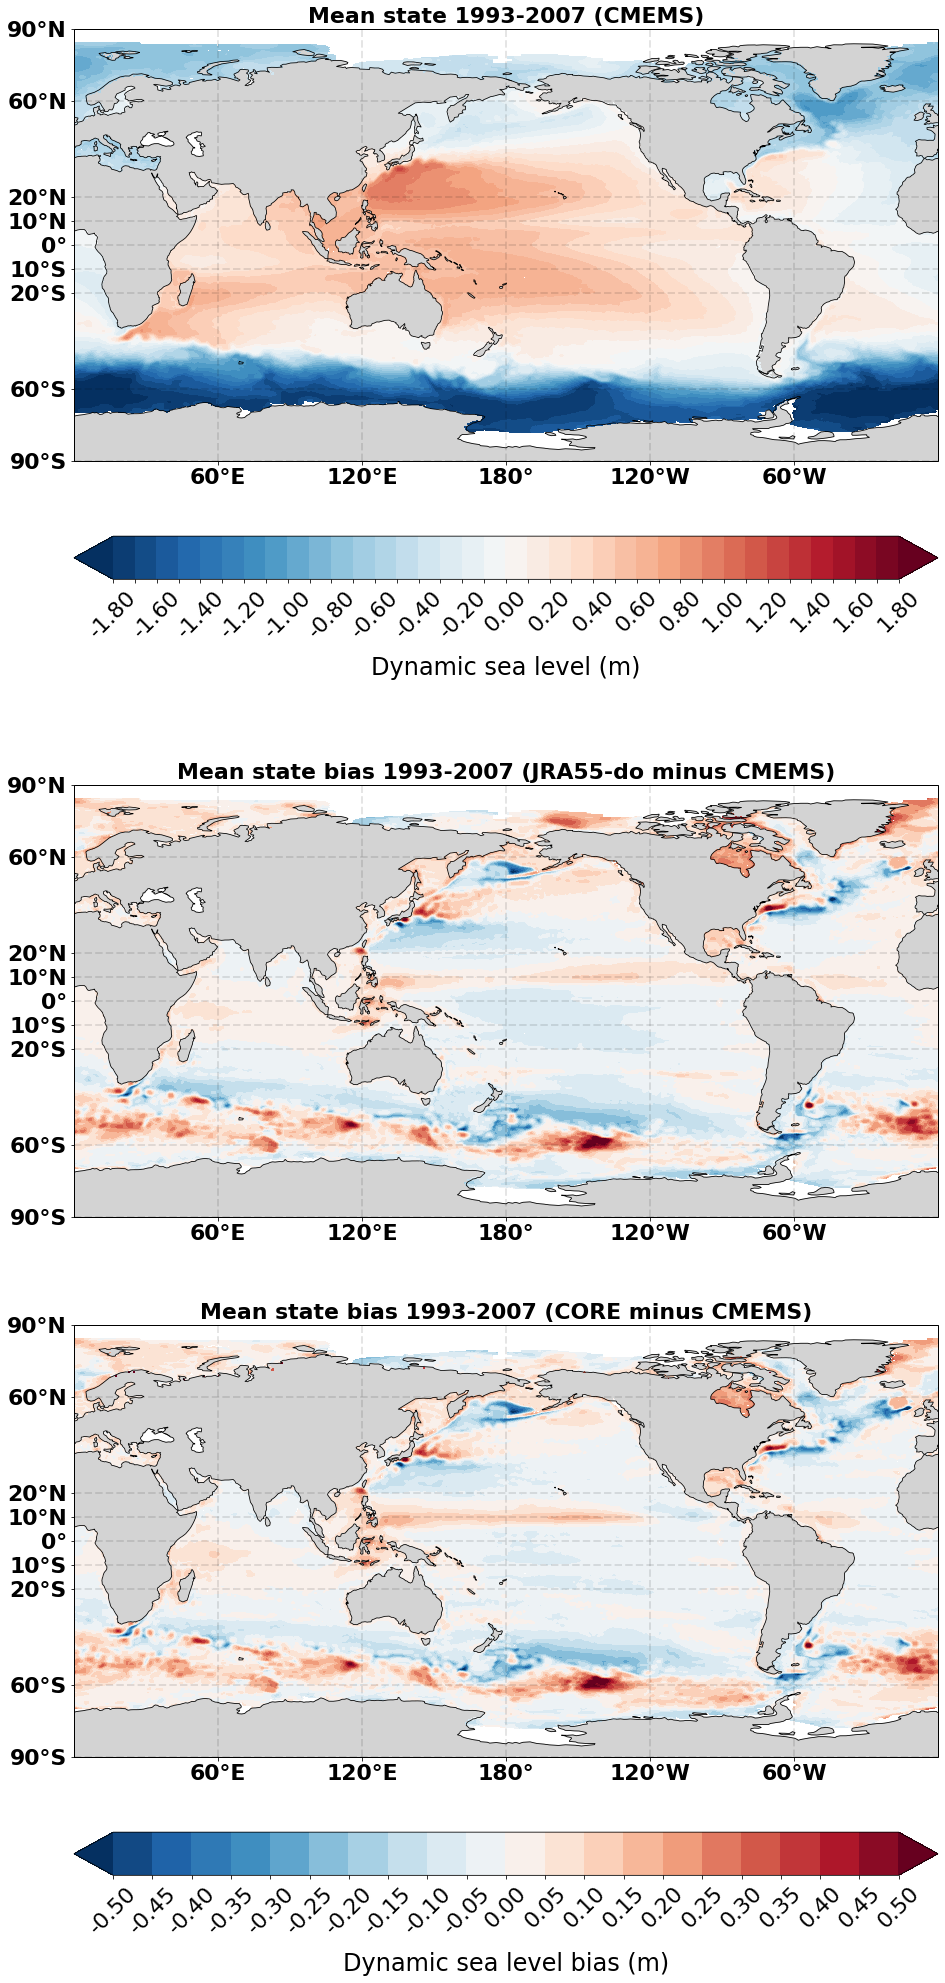

In [34]:
# comparing zos  
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig=plt.figure(2,figsize=(30,30))
devy = 0.25
abslevel=np.linspace(-1.8, 1.8, 18*2+1)
level=np.linspace(-0.5, 0.5, 21)

ax2=fig.add_axes([0,0,0.5,0.20],projection=ccrs.PlateCarree(central_longitude=180))
    
im=((obs_mean_mlist['CMEMS']['adt']))\
                 .plot.contourf(x='lon',
                                y='lat',
                                ax=ax2, 
                                levels=abslevel, 
                                extend='both', 
                                cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0))


cb=im.colorbar
cb.remove()
cbaxes=fig.add_axes([0,0-0.055,0.4,0.02])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(abslevel)

color_lable = []
for num,n in enumerate(abslevel) :
    if (num % 2) == 0 :
        color_lable.append("%0.2f"%(n))
    else:
        color_lable.append(" ")
cbar.set_ticklabels(color_lable)         
# cbar.set_ticklabels(["%0.2f"%(n) for n in abslevel if (n % 2) != 0]) 
cbar.ax.tick_params(labelsize=22,rotation=45) 
cbar.set_label(label='Dynamic sea level (m)',size=24, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')

ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-90,-60,-20,-10,0,10,20,60,90], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-90,-60,-20,-10,0,10,20,60,90], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.1, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Mean state 1993-2007 (CMEMS)', color='black', weight='bold',size=22)
ax2.set_aspect('auto')

#########################################################################################
# fig.text(-0.05,0.25,'a',size=30)
for nmodel,model in enumerate(Model_name):
    
    ax2=fig.add_axes([0,0-0.1-devy*(nmodel+1),0.5,0.2],projection=ccrs.PlateCarree(central_longitude=180))
    # ax2.set_extent([-180,180,-60,60],crs=ccrs.PlateCarree())
    da_diff = (mean_mlist[model]['zos']-obs_mean_mlist['CMEMS']['adt'])
    im=(da_diff-da_diff.mean(dim=['x','y']))\
                 .plot.contourf(x='lon',
                                y='lat',
                                ax=ax2, 
                                levels=level, 
                                extend='both', 
                                cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0))
#     ((mean_mlist[model]['zos']-obs_mean_mlist['CMEMS']['adt']))\
#                  .plot.contour(x='lon',
#                                 y='lat',
#                                 ax=ax2, 
#                                 levels=level, 
#                                 colors='k',
#                                 transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    
    if nmodel == len(Model_name)-1 :
        cbaxes=fig.add_axes([0,0-0.1-devy*(nmodel+1)-0.055,0.4,0.02])
        cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
        cbar.set_ticks(level)
        cbar.set_ticklabels(["%0.2f"%(n) for n in level]) #m => mm
        cbar.ax.tick_params(labelsize=22,rotation=45) 
        cbar.set_label(label='Dynamic sea level bias (m)',size=24, labelpad=15)
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')

    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-90,-60,-20,-10,0,10,20,60,90], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-90,-60,-20,-10,0,10,20,60,90], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax2.grid(linewidth=2, color='black', alpha=0.1, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_title('Mean state bias 1993-2007 (%s minus CMEMS)'%Model_legend_name[nmodel], color='black', weight='bold',size=22)
    ax2.set_aspect('auto')

fig.savefig('../figure/figure1_global.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)


No handles with labels found to put in legend.


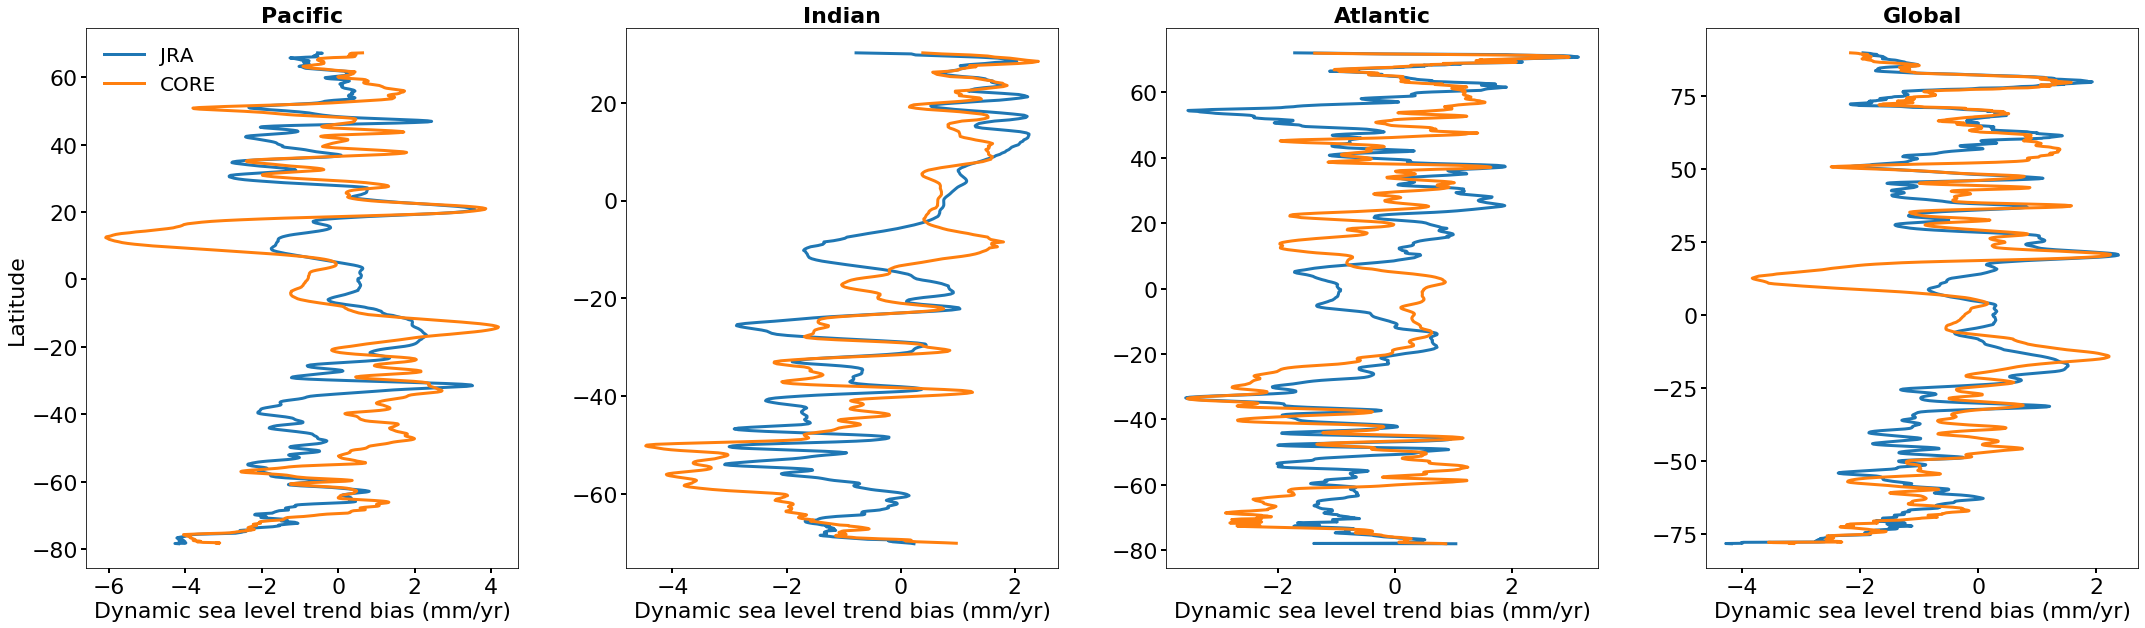

In [40]:
# comparing zos  
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig=plt.figure(2,figsize=(30,15))
devy = 0.25
level=np.linspace(-0.2, 0.2, 21)


    
#########################################################################################  
ax2=fig.add_axes([0,0,0.2,0.5])

da_obs_mean = (obs_linear_mlist_regrid['CMEMS']['adt'])*1000.
# (da_obs_mean*da_pacific).mean(dim=['x']).plot(ax=ax2,y='y',linewidth=3.0,label='CMEMS',color='k')

colors=['C0','C1']
for nmodel, model in enumerate(Model_name):

    #### plotting
    da_mean = (linear_mlist_regrid[model]['zos'])*1000.
    da_mean_bias = da_mean-da_obs_mean
#     da_mean_bias = da_mean_bias-da_mean_bias.mean(dim=['x','y'])
    
    (da_mean_bias*da_pacific).mean(dim='x').plot(ax=ax2,y='y',linewidth=3.0,label='%s'%model,color=colors[nmodel])

# ax2.set_xlim([0.35,0.79])
# ax2.set_yticks([-20,-10,0,10,20])
# ax2.set_yticklabels(['20$^\circ$S','10$^\circ$S','0$^\circ$','10$^\circ$N','20$^\circ$N'], color='black',size=22)
ax2.tick_params(axis='y',labelsize=22,length=5,width=2) 
ax2.tick_params(axis='x',labelsize=22,length=5,width=2) 
# ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_ylabel('Latitude',size=22)
ax2.set_xlabel('Dynamic sea level trend bias (mm/yr)',size=22)
ax2.set_title('Pacific',color='black', weight='bold',size=22)
ax2.legend(loc='upper left',fontsize=20,frameon=False)
# ax2.set_ylim([np.min(level),np.max(level)])
# ax2.legend(frameon=False,loc='upper right',bbox_to_anchor=(0, 1.2))

#########################################################################################  
ax2=fig.add_axes([0.25,0,0.2,0.5])

da_obs_mean = (obs_linear_mlist_regrid['CMEMS']['adt'])*1000.
# (da_obs_mean*da_indian).mean(dim=['x']).plot(ax=ax2,y='y',linewidth=3.0,label='CMEMS',color='k')

colors=['C0','C1']
for nmodel, model in enumerate(Model_name):

    #### plotting
    da_mean = (linear_mlist_regrid[model]['zos'])*1000.
    da_mean_bias = da_mean-da_obs_mean  
#     da_mean_bias = da_mean_bias-da_mean_bias.mean(dim=['x','y'])
    
    (da_mean_bias*da_indian).mean(dim='x').plot(ax=ax2,y='y',linewidth=3.0,label='%s'%model,color=colors[nmodel])

# ax2.set_xlim([0.35,0.79])
# ax2.set_yticks([-20,-10,0,10,20])
# ax2.set_yticklabels(['20$^\circ$S','10$^\circ$S','0$^\circ$','10$^\circ$N','20$^\circ$N'], color='black',size=22)
ax2.tick_params(axis='y',labelsize=22,length=5,width=2) 
ax2.tick_params(axis='x',labelsize=22,length=5,width=2) 
# ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_ylabel('',size=22)
ax2.set_xlabel('Dynamic sea level trend bias (mm/yr)',size=22)
ax2.set_title('Indian',color='black', weight='bold',size=22)
# ax2.legend(loc='upper left',fontsize=20,frameon=False)
# ax2.set_ylim([np.min(level),np.max(level)])

#########################################################################################  
ax2=fig.add_axes([0.5,0,0.2,0.5])

da_obs_mean = (obs_linear_mlist_regrid['CMEMS']['adt'])*1000.
# (da_obs_mean*da_atlantic).mean(dim=['x']).plot(ax=ax2,y='y',linewidth=3.0,label='CMEMS',color='k')

colors=['C0','C1']
for nmodel, model in enumerate(Model_name):

    #### plotting
    da_mean = (linear_mlist_regrid[model]['zos'])*1000.
    da_mean_bias = da_mean-da_obs_mean  
#     da_mean_bias = da_mean_bias-da_mean_bias.mean(dim=['x','y'])
    
    (da_mean_bias*da_atlantic).mean(dim='x').plot(ax=ax2,y='y',linewidth=3.0,label='%s'%model,color=colors[nmodel])

# ax2.set_xlim([0.35,0.79])
# ax2.set_yticks([-20,-10,0,10,20])
# ax2.set_yticklabels(['20$^\circ$S','10$^\circ$S','0$^\circ$','10$^\circ$N','20$^\circ$N'], color='black',size=22)
ax2.tick_params(axis='y',labelsize=22,length=5,width=2) 
ax2.tick_params(axis='x',labelsize=22,length=5,width=2) 
# ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_ylabel('',size=22)
ax2.set_xlabel('Dynamic sea level trend bias (mm/yr)',size=22)
ax2.set_title('Atlantic',color='black', weight='bold',size=22)
# ax2.legend(loc='upper left',fontsize=20,frameon=False)

#########################################################################################  
ax2=fig.add_axes([0.5+0.25,0,0.2,0.5])

da_obs_mean = (obs_linear_mlist_regrid['CMEMS']['adt'])*1000.
# (da_obs_mean*da_atlantic).mean(dim=['x']).plot(ax=ax2,y='y',linewidth=3.0,label='CMEMS',color='k')

colors=['C0','C1']
for nmodel, model in enumerate(Model_name):

    #### plotting
    da_mean = (linear_mlist_regrid[model]['zos'])*1000.
    da_mean_bias = da_mean-da_obs_mean  
#     da_mean_bias = da_mean_bias-da_mean_bias.mean(dim=['x','y'])
    
    glo_bias = (da_mean_bias*da_area).sum(dim=['x','y'])/(da_mean_bias/da_mean_bias*da_area).sum(dim=['x','y'])
    (da_mean_bias).mean(dim='x').plot(ax=ax2,y='y',linewidth=3.0,color=colors[nmodel])
    

# ax2.set_xlim([0.35,0.79])
# ax2.set_yticks([-20,-10,0,10,20])
# ax2.set_yticklabels(['20$^\circ$S','10$^\circ$S','0$^\circ$','10$^\circ$N','20$^\circ$N'], color='black',size=22)
ax2.tick_params(axis='y',labelsize=22,length=5,width=2) 
ax2.tick_params(axis='x',labelsize=22,length=5,width=2) 
# ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_ylabel('',size=22)
ax2.set_xlabel('Dynamic sea level trend bias (mm/yr)',size=22)
ax2.set_title('Global',color='black', weight='bold',size=22)
ax2.legend(loc='lower right',fontsize=18,frameon=False)



fig.savefig('../figure/figure_reply1_glo.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)
